In [46]:
import xml.etree.ElementTree as ET
import re
import os
import pandas as pd
import seaborn as sns

In [25]:
import numpy as np
def get_vehicle_data(output_dir, eval_labels):
   
    df = {"eval_label" : [],
          "depart" : [],
          "duration" : []}
    
    for eval_label in eval_labels:
        
        label = re.findall(r'_(\w+).',eval_label)[0]   
        tree = ET.parse(os.path.join(output_dir,eval_label))
        root = tree.getroot()
        
        for veh in root:
            df["eval_label"].append(label)
            df["depart"].append(float(veh.get("depart")))
            df["duration"].append(float(veh.get("duration")))

    return df

In [47]:
path = "./logs/Simple_Balanced_Negative_Reward/run_1"
labels = re.findall(r'tripinfo_\w+\.xml',' '.join(os.listdir(path)))

data = pd.DataFrame(get_vehicle_data(path,labels))

In [48]:
data.columns

Index(['eval_label', 'depart', 'duration'], dtype='object')

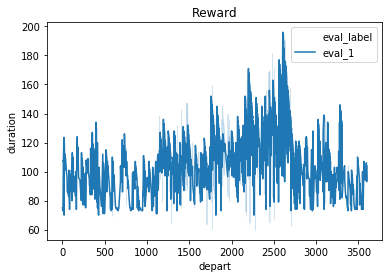

In [52]:
sns.lineplot(x = 'depart',    
             y = 'duration', 
             ci = 'sd', 
             hue = 'eval_label', 
             data = data[data["eval_label"] == "eval_1"],    legend = 'full').set_title("Reward");

In [5]:
res = {}
with open('./logs/Simple_Balanced_Negative_Reward/GS_results.json') as file:
    data = json.load(file)
    for run in data['results']:
        run_no = run["run"]
        res[f"{run_no}"] = [run["eval_mean_delay"], np.mean(run["eval_delay"]["episode_mean_delays_fixed"])]
        
res

{'7': [114.40562644971746, 127.83110766222171],
 '5': [100.85036202735317, 125.4137710310149],
 '3': [97.17223201002473, 133.63287232435806],
 '1': [111.50506902911563, 125.33017146268469],
 '8': [183.5087053129662, 126.87817405453018],
 '2': [285.1189825236969, 135.4103049075573],
 '4': [358.68338956144817, 129.3072330662541],
 '6': [307.8575253254659, 132.75914616771894],
 '9': [95.13617230615986, 126.05528590226095],
 '11': [97.51487404263534, 125.48718831414779],
 '10': [357.8092273855658, 127.10231879568971],
 '12': [416.7770184249026, 127.00048535536276]}